<a href="https://colab.research.google.com/github/nirezuluet/Federated-Learning-for-the-pathogenicity-annotation-of-genetic-variants/blob/main/FL_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a tutorial on how to use federated learning for the pathogenicity annotation of genetic variants in a multi-site clinical setting.

We will implement a federated learning project using the library flower. You can find more documentation and other examples on how to use flower here.

In this notebook, we will simulate a collaboration across 7 clinical genetic testing laboratories/ research institutions to train a machine learning model to classify copy number variants (CNVs) into pathogenic or non-pathogenic. If you do not know what CNVs are, you can read this blog post.

If you need a quick refresh on what federated learning is, you can also read this blog post.

# Installing Flower and PyThorch

You can install flower from pip. We will use the simulation engine as well.

In [6]:
!pip install -q "flwr[simulation]"

In this tutorial we are going to use PyTorch. Feel free to uncomment the following line if PyTorch is not already installed in your system.

In [7]:
# !pip install torch

# Exploratory data analysis (EDA)

The datasets used for this experiment can be downloaded from here.

It is basically composed of deletion CNVs, where each genetic variant is associated with the clinical genetic testing laboratory/research institution that reported it. We used ClinVar database and other reference databases to build a dataset containing CNVs matched by lenght.

Each CNV is represented by a set of bioinformatic features, a label indicating if it is non-pathogenic (0) or pathogenic (1), the chromosome where it is located, and its submitter. For this experiment we considered CNVs reported in ClinVar before January 1st 2022. In this dataset each submitter holds the same number of pathogenic and non-pathogenic variants. In other words, we have a balanced dataset.

If you are curious about the features describing each CNV, you can consult this paper.

Let's begin by an exploratory data analysis on the original dataset.

<ipython-input-34-f46aed3dcbcb>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


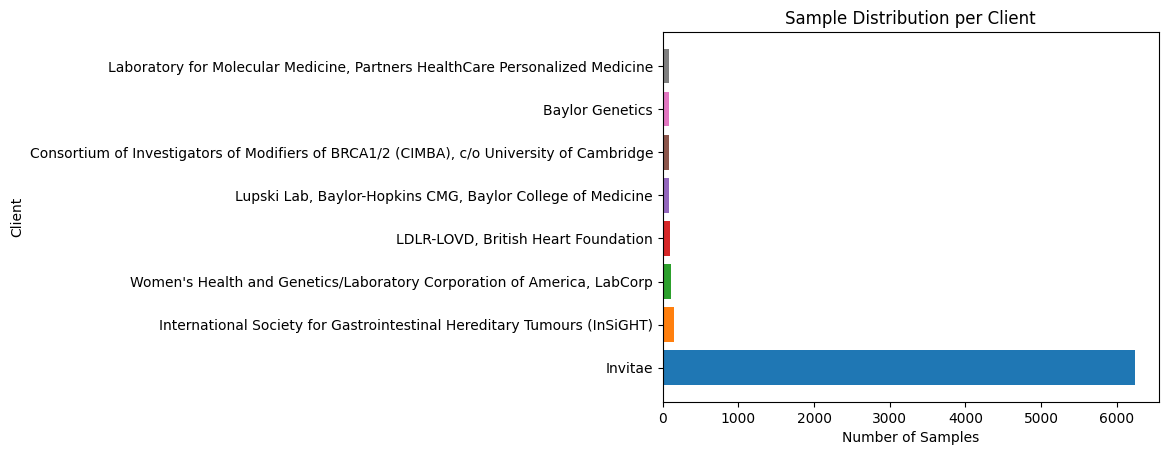

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def get_count_per_client(df):
  count_per_client = {}
  for idex, row in df.iterrows():
    if row["submitter"] in count_per_client:
      count_per_client[row["submitter"]] += 1
    else:
      count_per_client[row["submitter"]] = 1

  #sorting the dictionary in reverse order
  count_per_client = dict(sorted(count_per_client.items(), key=lambda item: item[1], reverse=True))
  return count_per_client


dataset = pd.read_csv("/content/sample_data/clinvar_deletion_final.csv")
count_per_client = get_count_per_client(dataset)

# Selecting the first 8 clients
client_count = list(count_per_client.values())[:8]
client_name = list(count_per_client.keys())[:8]

# Generate a list of random colors (or use a color palette)
colors = [plt.cm.tab10(i) for i in range(len(client_name))]  # tab10 has 10 distinct colors

# Plot horizontal bar chart
plt.barh(client_name, client_count, color=colors)
plt.xlabel('Number of Samples')
plt.ylabel('Client')
plt.title('Sample Distribution per Client')
plt.tight_layout()
plt.show()


Please, note that the decision of choosing 8 clients for the experiments is arbitrary. Feel free to change the number of clients, as well as selecting a different set of clients.

Here we can see that there is a client, called Invitae, that holds way more CNVs than the remaining institutions. Let's take a closer look to the distribution of CNVs of the smaller institutions.

<ipython-input-35-5093010e0760>:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


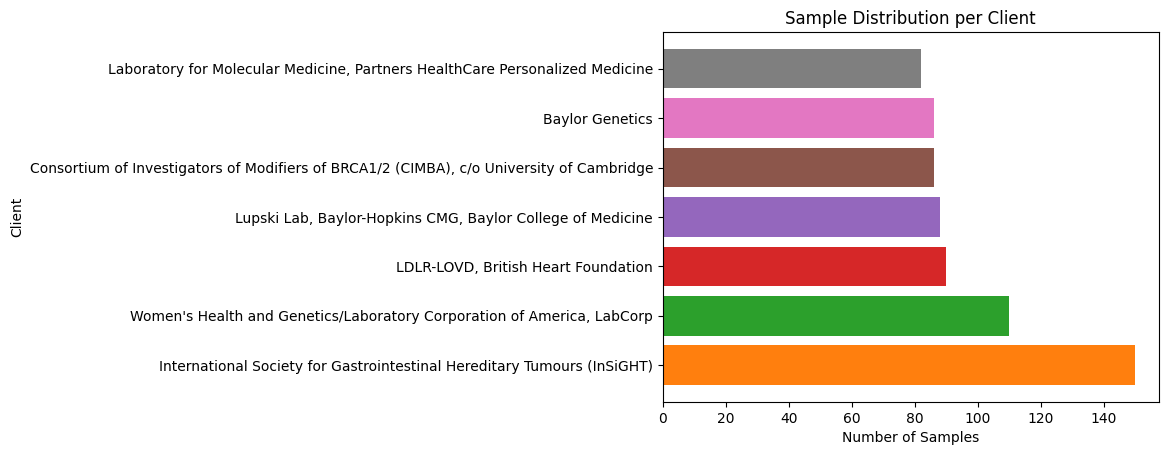

In [35]:
plt.barh(client_name[1:], client_count[1:], color=colors[1:])
plt.xlabel('Number of Samples')
plt.ylabel('Client')
plt.title('Sample Distribution per Client')
plt.tight_layout()
plt.show()

This set of clients represents a more balanced scenario for a collaboration. From the analysis of previous graphs, we can suspect that Invitae wouldn't be interested in a collaboration with the smaller clients. Why would it be, if it has a ton of data compared to the union of the smaller clients ?

In the following we will train a ML model for the pathogenicity classification of genetic variants across the smaller clients. We will also compare the performance of this model to the model that Invitae trains by only using its dataset.

# Centralized training

Let's suppose that clients can share their private datasets to train a ML model. In this case, we can use the traditional approach to ML that we know so far.

We will consider two scenarios (two ML models): 1) the first, trained on Invitae's dataset, 2) the second, trained on the union of the smaller clients.

In this experiment, we will train a simple multilayer perceptron (MLP) following a leave-one-chromosome-out approach. This means that, instead of training a general ML model, we will train a pool of 23 models, one per chromosome. For example, to predict a CNVs located in chromosome 1, we will use a model trained on CNVs located inn chromosomes 2,3, ... X.

First, let's define the model

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = nn.functional.log_softmax(self.fc2(out), dim = 1)
    return out

Now, let's define the functions for preprocessing the train and validation sets for the two scenarios considered.

In [232]:
# data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def preprocess_data(df):

  # this method returns the features, the labels, and the scaler

  df_ = df.drop(["chrom","start","end","type_variant","source","id",
                "disease", "omim", "hi", "gene_hpo", "prot_complex",
                "essent_cl", "essent_dl", "blacklist", "hits_del",
                "hits_dup", "clinvar", "gwas", "tads", "max_obs_exp", "n_genes"], axis = 1)

  labels = np.array(np.where(df["clinical"] == "pathogenic",1,0), dtype = np.int64)
  df_ = df_.drop(["clinical", "submitter"], axis = 1)

  X = df_.to_numpy(dtype = "float32")

  #all the features are numerical
  min_max_scaler = MinMaxScaler()
  min_max_scaler.fit(df_.values)

  return X, labels, min_max_scaler


def train_validation_splits(df, chromosome):

  # the train set is formed by all CNVs, except those located in the given chromosome
  # the test set is formed by all CNVs located in the given chromosome

  df_train = df[df["chrom"] != chromosome]
  df_val = df[df["chrom"] == chromosome]

  X_train, y_train, scaler_train = preprocess_data(df_train)
  X_val, y_val, scaler_test = preprocess_data(df_val)

  #scaling values in train and validation sets
  X_train = scaler_train.transform(X_train)
  X_val = scaler_train.transform(X_val)

  return X_train, y_train, X_val, y_val, scaler_train


Let's construct the functions to train the MLP model and to evaluate its performance on held-out data.

In [224]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_curve, auc

#training method implementing early stopping in the validation set
def train(model, X_train, y_train, X_val, y_val, param_training):

  batch_size = param_training["batch_size"]
  learning_rate = param_training["learning_rate"]
  weight_decay = param_training["weight_decay"]
  epochs = param_training["epochs"]
  device = torch.device(param_training["device"])
  threshold_to_evaluate = param_training["threshold_to_evaluate"]

  min_test_loss = float("inf")


  train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
  trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)

  val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
  val_loader = DataLoader(val_dataset, batch_size = len(y_val), shuffle = False)

  optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay = weight_decay)
  model.train()

  for epoch in range(epochs):

      avg_loss = []

      for i, data in enumerate(trainloader,0):

          data, labels = data[0].to(device), data[1].to(device)

          #zero the parameter gradients
          optimizer.zero_grad()
          output = model(data)

          loss = torch.nn.functional.nll_loss(output,labels.long())
          loss.backward()
          avg_loss.append(loss.item())
          optimizer.step()

      if epoch % threshold_to_evaluate == threshold_to_evaluate - 1:

          # evaluating the model in the test set
          with torch.no_grad():

              model.eval()

              for data in val_loader:

                  val_data, val_labels = data[0].to(device), data[1].to(device)
                  val_output = model(val_data)
                  loss_ = torch.nn.functional.nll_loss(val_output, val_labels.long())

                  #printing train and validation losses
                  print(f"Epoch {epoch} Loss train {np.mean(avg_loss)}")
                  print(f"Epoch {epoch} Loss validation {loss_}")

                  # implementing early stopping

                  if loss_ <= min_test_loss:
                      min_test_loss = loss_.item()
                  else:
                      return model

  return model

#evaluating the model on a held-out dataset
def evaluate(model, X_test, y_test, param_eval):

  device = torch.device(param_eval["device"])

  test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
  test_dataloader = DataLoader(test_dataset, batch_size = len(y_test), shuffle = False)
  auc_roc = None
  prediction_prob = None


  with torch.no_grad():

    model.eval()

    for data in test_dataloader:

      test_data, test_labels = data[0].to(device), data[1].to(device)
      log_probs = model(test_data)  # model outputs log-probabilities
      probs = torch.exp(log_probs)  # convert log-probs to probabilities

      prediction_prob = probs[:, 1].cpu().numpy()  # get class 1 probabilities
      y_true = test_labels.cpu().numpy().astype(int)

      # Optional: print predicted class labels if needed
      _, predicted_labels = torch.max(log_probs.data.cpu(), 1)
      #print(predicted_labels)
      #print(prediction_prob)

      # Compute ROC curve and AUC
      fpr, tpr, thresholds = roc_curve(y_true, prediction_prob)
      auc_roc = auc(fpr, tpr)

      #computing accuracy
      acc = np.sum(predicted_labels.numpy() == y_true) / len(y_true)


  return auc_roc, prediction_prob, acc

Let's train the model of Invitae:

In [237]:
import copy

chromosomes = [str(i) for i in range(1,23)]
chromosomes.append("X")
#chromosomes = ["1"]
#getting all the samples submitted by Invitae
df_Invitae = dataset[dataset["submitter"] == "Invitae"]

bundle_models = [] #a list containing the 23 models

param_training = {
    "batch_size": 32,
    "learning_rate":0.01,
    "weight_decay":  0.00001,
    "epochs": 100 ,
    "device":"cpu",
    "threshold_to_evaluate": 20
    }

for chromosome in chromosomes:
  X_train, y_train, X_val, y_val, _ = train_validation_splits(df_Invitae, chromosome)
  model = Net(input_size = X_train.shape[1], hidden_size = 7, num_classes = 2)
  print(f'Training model chromosome {chromosome}')
  model = train(model, X_train, y_train, X_val, y_val, param_training)
  print(f'Training of model chromosome {chromosome} completed')
  model_copy = copy.deepcopy(model)
  bundle_models.append(model_copy)

Training model chromosome 1
Epoch 19 Loss train 0.01664780261233188
Epoch 19 Loss validation 0.09784182161092758
Epoch 39 Loss train 0.01205593549207651
Epoch 39 Loss validation 0.051403723657131195
Epoch 59 Loss train 0.006432640637161977
Epoch 59 Loss validation 0.07469731569290161
Training of model chromosome 1 completed
Training model chromosome 2


KeyboardInterrupt: 

In [222]:
from sklearn.metrics import precision_recall_curve, auc
# Evaluating the model on the CNVs that were not submitted by Invitae or the smaller clients
submitters = client_name
test_df = dataset[~dataset["submitter"].isin(submitters)]

param_eval = {
    "device":"cpu"
}

y_label, prob, avg_acc = [], [], []
for i in range(len(chromosomes)):
  chr_df = test_df[test_df["chrom"] == chromosomes[i]]
  X_test, y_test, scaler = preprocess_data(chr_df)
  X_test = scaler.transform(X_test)
  auc_roc, prediction_prob, acc = evaluate(bundle_models[i], X_test, y_test, param_eval)
  y_label.extend(y_test)
  prob.extend(prediction_prob)
  avg_acc.append(acc)

print(f"Average accuracy: {np.mean(avg_acc)}")

fpr, tpr, thresholds = roc_curve(y_label, prob)
auc_roc = auc(fpr, tpr)

print(f'AUC ROC: {auc_roc}')

Average accuracy: 0.9714584879180039
AUC ROC: 0.9871114188981225


In [148]:
print(scaler.__dict__)

{'feature_range': (0, 1), 'copy': True, 'clip': False, 'n_features_in_': 41, 'n_samples_seen_': 49, 'scale_': array([1.32152769e-04, 2.63095583e-06, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.02040816e-02, 8.30564784e-01, 1.01010101e-02,
       1.01010101e-02, 1.00000000e+00, 1.01010101e-02, 1.53846154e-02,
       1.00000000e-01, 1.00000000e-01, 1.16279070e-02, 3.84615385e-02,
       1.00000000e+00, 1.00000000e+00, 6.15307260e+03, 5.00000000e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.62326730e-03, 1.09945485e-02, 1.40424199e-02,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.43902439e-02,
       1.00000000e+00, 1.84438230e+02, 1.48750877e+02, 1.00000000e+00,
       9.09092209e+01, 1.00000000e+00, 1.00000000e+00, 1.83546860e-02,
       1.62337662e-01]), 'min_': array([-5.28611074e-03, -1.31547791e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.30066445e-01,  0.00000000e+0

In [235]:
# training the model of the smaller clients
df_smaller_clients = dataset[dataset["submitter"].isin(submitters[1:])]

bundle_models_smaller_clients = [] #a list containing the 23 models

param_training = {
    "batch_size": 32,
    "learning_rate":0.01,
    "weight_decay":  0.00001,
    "epochs": 100 ,
    "device":"cpu",
    "threshold_to_evaluate": 20
    }

scaler_train_list = []
for chromosome in chromosomes:
  X_train, y_train, X_val, y_val, scaler_train = train_validation_splits(df_smaller_clients, chromosome)
  model = Net(input_size = X_train.shape[1], hidden_size = 7, num_classes = 2)
  print(f'Training model chromosome {chromosome}')
  model = train(model, X_train, y_train, X_val, y_val, param_training)
  print(f'Training of model chromosome {chromosome} completed')
  model_copy = copy.deepcopy(model)
  bundle_models_smaller_clients.append(model_copy)

  scaler_train_list.append(copy.deepcopy(scaler_train))


Training model chromosome 1
Epoch 19 Loss train 0.19046430215239524
Epoch 19 Loss validation 0.4390490651130676
Epoch 39 Loss train 0.07631595470011235
Epoch 39 Loss validation 0.20757101476192474
Epoch 59 Loss train 0.033956332877278325
Epoch 59 Loss validation 0.1153072640299797
Epoch 79 Loss train 0.017161467066034674
Epoch 79 Loss validation 0.09076064825057983
Epoch 99 Loss train 0.011132441880181431
Epoch 99 Loss validation 0.08448302000761032
Training of model chromosome 1 completed
Training model chromosome 2
Epoch 19 Loss train 0.24108612449730144
Epoch 19 Loss validation 0.458061158657074
Epoch 39 Loss train 0.10205392057404798
Epoch 39 Loss validation 0.4126878082752228
Epoch 59 Loss train 0.052105880945044404
Epoch 59 Loss validation 0.2956491708755493
Epoch 79 Loss train 0.029112006208914167
Epoch 79 Loss validation 0.199192076921463
Epoch 99 Loss train 0.01974243248867638
Epoch 99 Loss validation 0.14156582951545715
Training of model chromosome 2 completed
Training model 

In [236]:

y_label, prob, avg_acc = [], [], []


for i in range(len(chromosomes)):

  chr_df = test_df[test_df["chrom"] == chromosomes[i]]

  X_test, y_test, scaler = preprocess_data(chr_df)
  X_test = scaler_train_list[i].transform(X_test)

  auc_roc, prediction_prob, acc = evaluate(bundle_models_smaller_clients[i], X_test, y_test, param_eval)
  y_label.extend(y_test)
  prob.extend(prediction_prob)
  avg_acc.append(acc)

print(f"Average accuracy: {np.mean(avg_acc)}")

fpr, tpr, thresholds = roc_curve(y_label, prob)
auc_roc = auc(fpr, tpr)

print(f'AUC ROC: {auc_roc}')

Average accuracy: 0.9683781468281395
AUC ROC: 0.994656475496734


In [176]:
print(scaler.data_min_)      # Min value per feature in X_train
print(scaler.data_max_)      # Max value per feature
print(scaler.data_range_)    # Range per feature

[ 4.00000000e+01  5.00000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.77000000e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.00000000e+00  4.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.44405806e-16  1.79305900e+00  8.79038000e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.51800000e+00
  0.00000000e+00]
[7.60700000e+03 3.80140000e+05 0.00000000e+00 0.00000000e+00
 1.00000000e+00 9.80000000e+01 9.27000000e-01 9.90000000e+01
 9.90000000e+01 0.00000000e+00 9.90000000e+01 6.50000000e+01
 1.00000000e+01 1.00000000e+01 8.60000000e+01 2.60000000e+01
 4.00000000e+00 5.00000000e+00 1.62520429e-04 2.00000000e+00
 0.00000000e+00 0.00000000e

# Federated Learning

In [40]:
df_Invitae.head()

,Unnamed: 0,chrom,start,end,type_variant,clinical,source,length_cnv,id,disease,...,tfbs,ucne,clinvar,gwas,tads,max_cadd,max_gerp,max_obs_exp,n_genes,submitter
0,0,5,112173250,112181936,deletion,pathogenic,clinvar,8687,560547,1,...,0.0,0,1,1,0,44.0,6.17,1.0000,1,Invitae
1,1,9,140128413,140128513,deletion,pathogenic,clinvar,101,560548,1,...,0.0,0,0,0,0,40.0,3.58,0.3362,1,Invitae
4,4,19,7586622,7593055,deletion,pathogenic,clinvar,6434,560552,1,...,0.0,0,1,1,0,48.0,5.48,0.9978,1,Invitae
58,58,17,41222945,41226538,deletion,pathogenic,clinvar,3594,561176,1,...,0.0,0,1,1,0,62.0,5.54,0.9324,1,Invitae
59,59,17,41219625,41219712,deletion,pathogenic,clinvar,88,561177,1,...,0.0,0,1,0,0,51.0,5.24,0.0000,1,Invitae


In [28]:
client_count

[6244, 150, 110, 90, 88, 86, 86, 82]

In [12]:
# first fixing the data that Paco gave me
import pandas as pd

df = pd.read_csv("/content/sample_data/clinvar_deletion.tsv", sep="\t")

#separate the pathogenic from the non-pathogenic
df_pathogenic = df[df["clinical"] == "pathogenic"]
df_non_pathogenic = df[df["clinical"] != "pathogenic"]


In [16]:
df_pathogenic.head()

,chrom,start,end,type_variant,clinical,source,length_cnv,id,disease,omim,...,tfbs,ucne,clinvar,gwas,tads,max_cadd,max_gerp,max_obs_exp,n_genes,submitter
0,5,112173250,112181936,deletion,pathogenic,clinvar,8687,560547,1,1,...,0.0,0,1,1,0,44.0,6.17,1.0000,1,Invitae
1,9,140128413,140128513,deletion,pathogenic,clinvar,101,560548,1,1,...,0.0,0,0,0,0,40.0,3.58,0.3362,1,Invitae
2,19,11200292,11215895,deletion,pathogenic,clinvar,15604,560550,1,1,...,0.0,0,1,1,0,41.0,5.65,0.9998,1,OMIM
3,19,11211022,11223953,deletion,pathogenic,clinvar,12932,560551,1,1,...,0.0,0,1,1,0,44.0,5.65,0.9949,1,OMIM
4,19,7586622,7593055,deletion,pathogenic,clinvar,6434,560552,1,1,...,0.0,0,1,1,0,48.0,5.48,0.9978,1,Invitae


In [15]:
#reading the file that contains the match in length
df_match = pd.read_csv("/content/sample_data/match_patho_benign_clinvar_deletion.tsv", sep="\t")
df_match.head()

,id,id_match
0,560547,140249
1,560548,141352
2,560550,166991
3,560551,148865
4,560552,145402


In [17]:
#modifying the original dataframe to change the submitter name in the benign variant

#creating a hash table for quick access non-pathogenic - pathogenic
dic = {}
for idex, row in df_match.iterrows():
  dic[int(row["id_match"])] = int(row["id"])

#creating a hash table for quick access pathogenic - submitter
dic2 = {}
for idex, row in df_pathogenic.iterrows():
  dic2[int(row["id"])] = row["submitter"]


# changing the submiter of the non-pathogenic
for idex, row in df.iterrows():
  if int(row["id"]) in dic:
    df.at[idex, "submitter"] = dic2[dic[int(row["id"])]]

In [22]:
#saving the dataframe
df.to_csv("/content/sample_data/clinvar_deletion_final.csv")

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


def get_count_per_client(df_train):
  count_per_client = {}
  for idex, row in df_train.iterrows():
    if row["submitter"] in count_per_client:
      count_per_client[row["submitter"]] += 1
    else:
      count_per_client[row["submitter"]] = 1

  return count_per_client




In [26]:
count_per_client = get_count_per_client(df)

#sorting the clients in reverse order
count_per_client = dict(sorted(count_per_client.items(), key=lambda item: item[1], reverse=True))
list(count_per_client.items())[:8]

[('Invitae', 6244),
 ('International Society for Gastrointestinal Hereditary Tumours (InSiGHT)',
  150),
 ("Women's Health and Genetics/Laboratory Corporation of America, LabCorp",
  110),
 ('LDLR-LOVD, British Heart Foundation', 90),
 ('Lupski Lab, Baylor-Hopkins CMG, Baylor College of Medicine', 88),
 ('Consortium of Investigators of Modifiers of BRCA1/2 (CIMBA), c/o University of Cambridge',
  86),
 ('Baylor Genetics', 86),
 ('Laboratory for Molecular Medicine, Partners HealthCare Personalized Medicine',
  82)]